# DeepDream

In [1]:
import tensorflow as tf

In [2]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

## Selecting an image to apply deep dream

In [3]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/My\ Drive/Colab Notebooks/

/content/drive/My Drive/Colab Notebooks


(1049, 1042, 3)


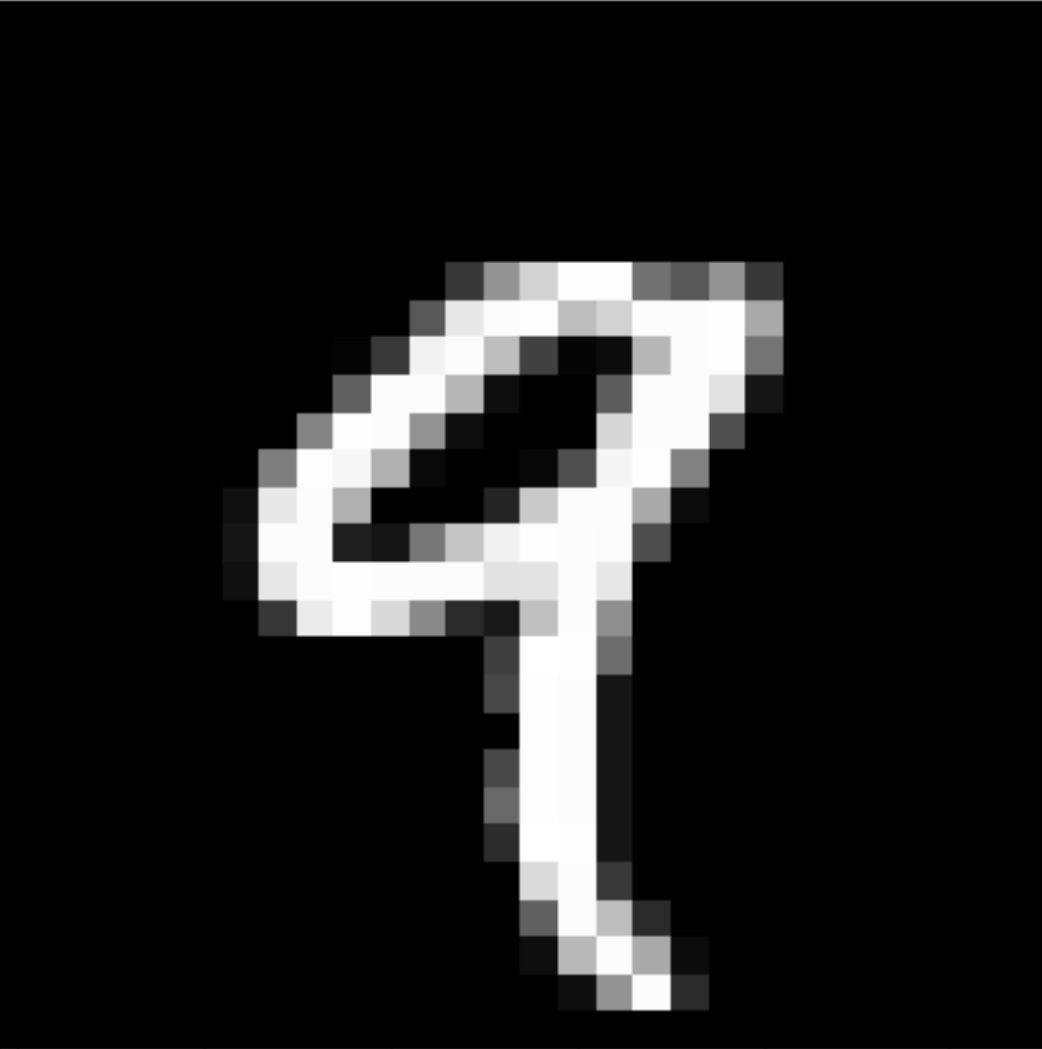

In [5]:
# Upload an image and convert to NumPy array.
def upload(max_dim=None):
  img = PIL.Image.open((('nine-one.jpg')))
  print(np.array(img).shape)
  return np.array(img)

# Normalizing the image
def de_process(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = upload(max_dim=100)
show(original_img)

## Feature extraction model Preparation

In [6]:
# USing InceptionV3 as the base model
base_d_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [7]:
# The idea behind deep dream is to print the inner working of the layers by picking a layer and maximizing the loss at a certain layer
# Inception V3 has 11 layers, deeper layers have higher level features
# Maximizing the layers activations 
dd_names = ['mixed9', 'mixed10']
layers = [base_d_model.get_layer(name).output for name in dd_names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_d_model.input, outputs=layers)

In [8]:
def calc_dd_loss(img, model):
  # Retrieving the activations by passing the image forward through the model 
  img_dd_batch = tf.expand_dims(img, axis=0)
  layer_dd_activations = model(img_dd_batch)
  if len(layer_dd_activations) == 1:
    layer_dd_activations = [layer_dd_activations]

  losses_dd = []
  for act in layer_dd_activations:
    loss = tf.math.reduce_mean(act)
    losses_dd.append(loss)

  return  tf.reduce_sum(losses_dd)

## Gradient ascent

In [9]:
# Maximizing loss via gradient asecent rather than minimizing with gradient to better visualize the patterns excited/seen by the network 
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape_dd:     
          tape_dd.watch(img)
          loss = calc_dd_loss(img, self.model)

        # Generate the gradient of the loss wrt the pixels of the input image.
        gradients = tape_dd.gradient(loss, img)

        # Normalizing gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [10]:
deepdream = DeepDream(dream_model)

## Main DD Loop

In [11]:
def run_dd_simple(img, steps=100, step_size=0.01):
  # Converting uint8 to the range needed for the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_dd_remaining = steps
  step = 0
  while steps_dd_remaining:
    if steps_dd_remaining>100:
      run_dd_steps = tf.constant(100)
    else:
      run_dd_steps = tf.constant(steps_dd_remaining)
    steps_dd_remaining -= run_dd_steps
    step += run_dd_steps

    loss, img = deepdream(img, run_dd_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(de_process(img))
    print ("Step {}, loss {}".format(step, loss))


  result_dd = de_process(img)
  display.clear_output(wait=True)
  show(result_dd)

  return result_dd

In [12]:
dream_img = run_dd_simple(img=original_img, 
                                  steps=100, step_size=0.01)

Output hidden; open in https://colab.research.google.com to view.

## Octave increase

Apply gradient ascent at multiple scales. This is done to allow paterns that were created at a smaller scale to be created at larger scale with more detail.

Apply gradient ascent and increase image size

In [13]:
import time
start = time.time()

OCTAVE_DD_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_dd_shape = tf.shape(img)[:-1]
float_dd_base_shape = tf.cast(base_dd_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_dd_base_shape*(OCTAVE_DD_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_dd_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_dd_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

Output hidden; open in https://colab.research.google.com to view.

## Scaling up with tiles


The image can be split into tiles for which the gradient can be computed in order to steer away from large image sizes. 

Random shifts can be applied to avoid tile seams showing in the image

Starting with random shift:

In [14]:
def random_dd_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_dd_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_dd_rolled

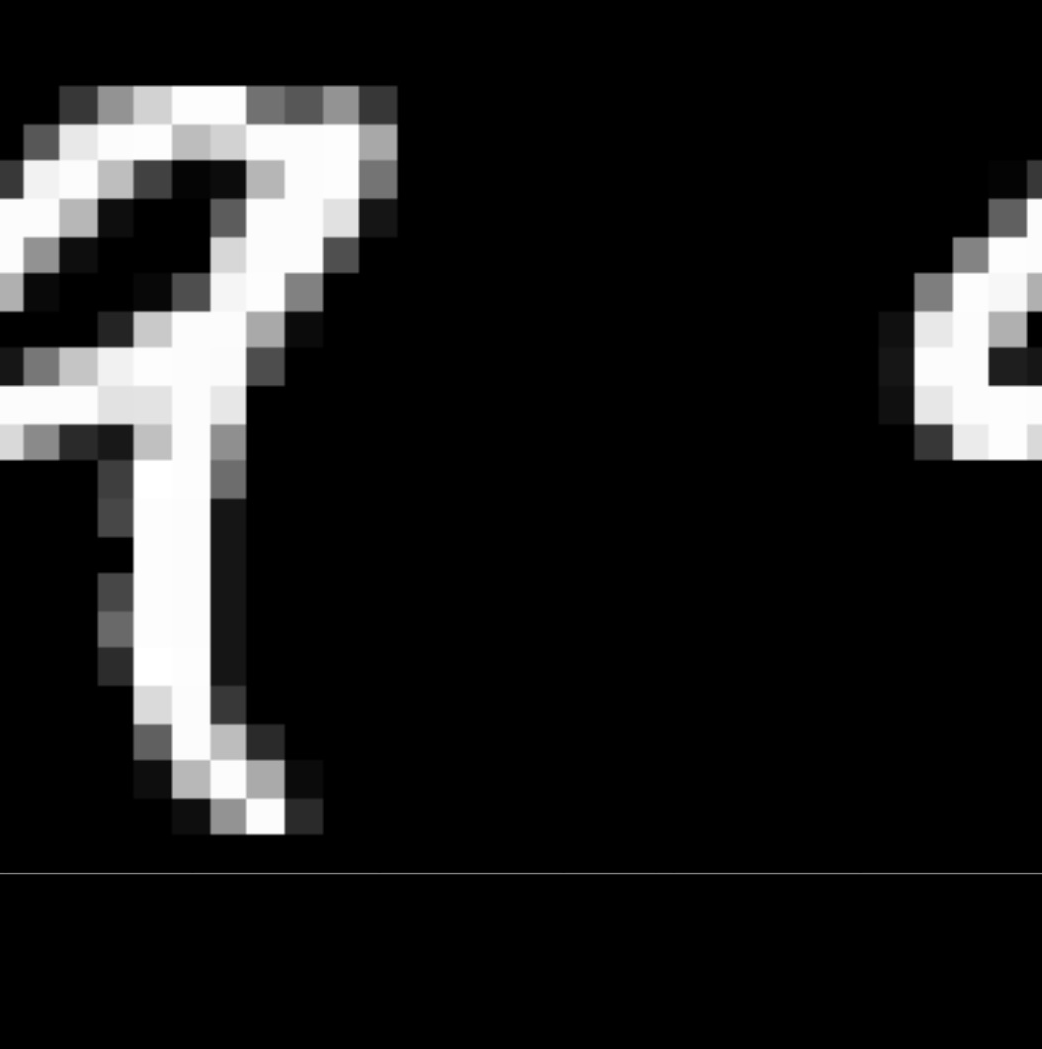

In [15]:
shift, img_rolled = random_dd_roll(np.array(original_img), 512)
show(img_rolled)

Below is a tiled parallel of the `deepdream` function that was defined previously:

In [16]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_dd_roll(img, tile_size)

    # Initializing image gradients to 0.
    gradients = tf.zeros_like(img_rolled)
    
    # Skiping final tile, exceot if there's only one tile.
    xs_dd = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs_dd), bool):
      xs_dd = tf.constant([0])
    ys_dd = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys_dd), bool):
      ys_dd = tf.constant([0])

    for x in xs_dd:
      for y in ys_dd:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape_dd:
          tape_dd.watch(img_rolled)

          # Extracting a tile from the image.
          img_dd_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_dd_loss(img_dd_tile, self.model)

        # Updating the gradients of the image for the tile.
        gradients = gradients + tape_dd.gradient(loss, img_rolled)

    # Undo the random shift implemented on the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [17]:
get_dd_tiled_gradients = TiledGradients(dream_model)

Joining all together for a scalable, octave-aware deepdream implementation:

In [18]:
def run_dd_with_octaves(img, steps_per_octave=100, step_size=0.01, 
                                octaves=range(-2,3), octave_scale=1.3):
  base_dd_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  initial_dd_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_dd_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_dd_size = tf.cast(tf.convert_to_tensor(base_dd_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_dd_size = tf.cast(new_dd_size, tf.int32)
    img = tf.image.resize(img, new_dd_size)

    for step in range(steps_per_octave):
      gradients = get_dd_tiled_gradients(img, new_dd_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(de_process(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result_dd = de_process(img)
  return result_dd

In [19]:
img = run_dd_with_octaves(img=original_img, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_dd_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

Output hidden; open in https://colab.research.google.com to view.

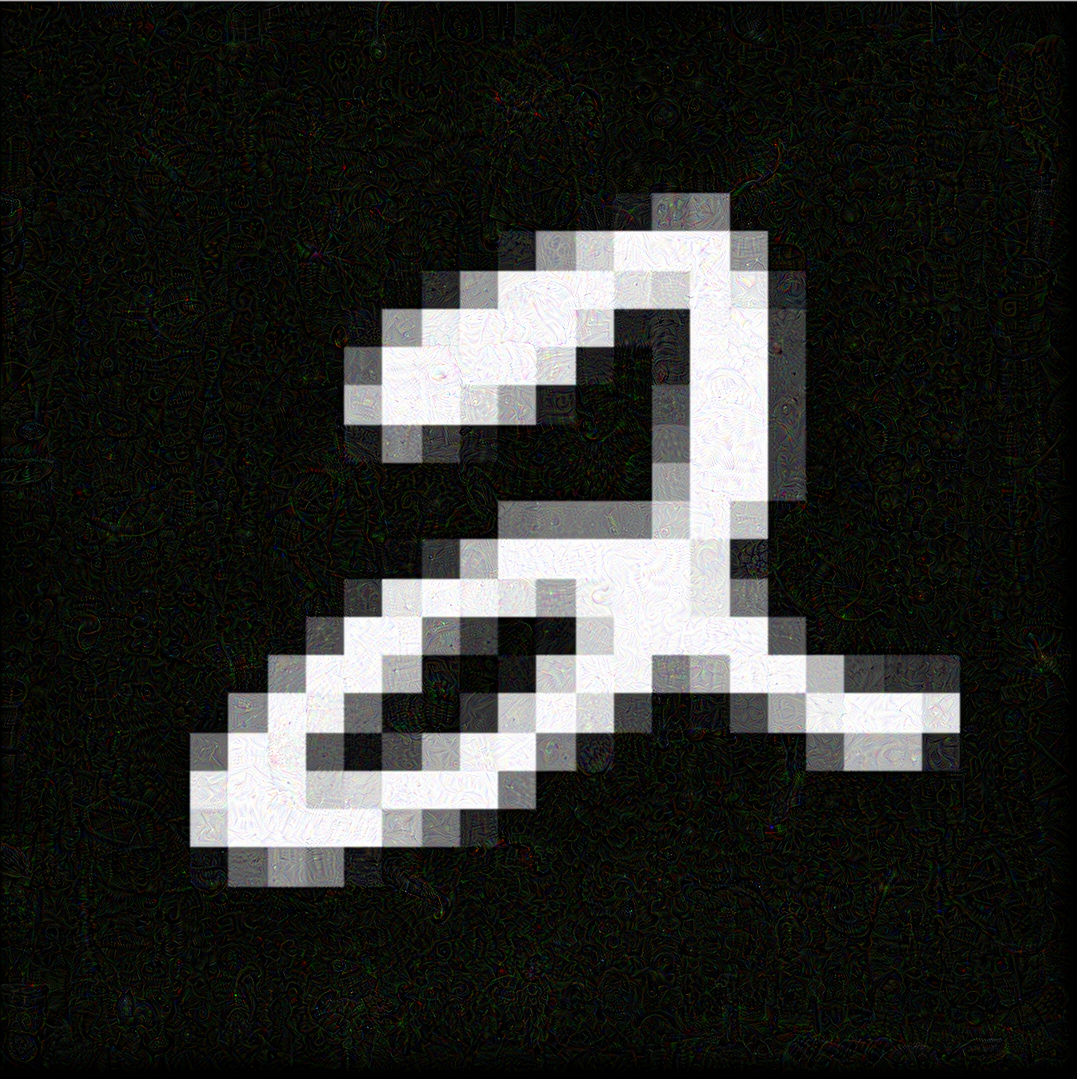

In [20]:
def upload(max_dim=None):
  img = PIL.Image.open((('two-one.jpg')))
  print(np.array(img).shape)
  return np.array(img)

original_img = upload(max_dim=100)
show(original_img)

dd_names = ['mixed9', 'mixed10']
layers = [base_d_model.get_layer(name).output for name in dd_names]
dream_model = tf.keras.Model(inputs=base_d_model.input, outputs=layers)
deepdream = DeepDream(dream_model)
dream_img = run_dd_simple(img=original_img, 
                                  steps=100, step_size=0.01)

Reference - https://keras.io/examples/generative/deep_dream/